In [124]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline
import matplotlib.colors as mcolors
import matplotlib as pl
import scipy.optimize as op
import emcee
from pylab import cm

Populating the interactive namespace from numpy and matplotlib


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'ndim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [125]:
velocity = np.loadtxt("phase_space_zmin0.1_zmax0.2_withlam_withz.dat")

In [126]:
def mass_richness_sv(richness,z):
    #From SV paper
    M_0 = 2.35e14
    lambda_0 = 30.
    z_0 = 0.5
    F = 1.12
    G = 0.11
    #No factors of h
    M200m = M_0*((richness/lambda_0)**F)*((1.+z)/(1.+z_0))**G
    return M200m 

In [128]:
R = velocity[:,0]
dz = velocity[:,1]
Lambda = velocity[:,5]
z = velocity[:,6]
Mag_g = velocity[:,2]
Mag_r = velocity[:,3]
mean_lambda = np.mean(Lambda)
R_scale = R/(Lambda/mean_lambda)**(1./3)
mean_z = np.mean(z)


mask_r = (Mag_g-Mag_r)<np.percentile(Mag_g-Mag_r, 50)
R = R[mask_r]
dz = dz[mask_r]
Lambda =Lambda[mask_r]
z =z[mask_r]

print('mean_lambda', mean_lambda)
print('mean_z', mean_z)
print('mean_mass', mass_richness_sv(mean_lambda, mean_z))

mean_lambda 34.259812737474704
mean_z 0.14696825142724076
mean_mass 264747492271605.62


In [129]:
p0 = [0.001, 0.3, 0.1]
bounds = ((0.0001,0.1), (-1,1.5), (0.01,0.99))

def lnlikelihood(params, dz, lamb):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params

    if p>1:
        lnlike_out = -1.0e10
    else:
        sigma  = sigma0* (lamb/30.0)**alpha
        like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*dz**2/sigma**2) + (1.-p)/0.04 #*(B*dz -0.02*B + 1./0.04 + 0.02*0.04)
        lnlike_out = np.sum(np.log(like))

#     print(lnlike_out)
    return lnlike_out

def lnprior(params):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params
    if (sigma0<bounds[0][0]) or (sigma0>bounds[0][1]) or (alpha<bounds[1][0]) or (alpha>bounds[1][1]) or (p<bounds[2][0]) or (p>bounds[2][1]):
        lnprior = -1.0e10
    else:
        lnprior = 1000.
#     print(lnprior)
    return lnprior

def lnposterior(params, dz, lamb):

    lnpriors = lnprior(params)
    lnlike = lnlikelihood(params, dz, lamb)
    lnposterior = lnlike + lnpriors
#     print(lnlike, lnpriors,lnposterior)
    return lnposterior


nll = lambda *args: -lnlikelihood(*args)
method = 'L-BFGS-B'

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[0.00262061 0.65835407 0.99      ]
Running sampler...
Done running sampler
[0.00232381 0.91242009 0.95317759]
Running sampler...
Done running sampler
[ 0.00292237 -0.30063282  0.9129487 ]
Running sampler...
Done running sampler
[0.0020786  1.00045971 0.94719248]
Running sampler...
Done running sampler
[0.00278432 0.26090997 0.97713895]
Running sampler...
Done running sampler
[0.00287282 0.47288379 0.91264536]
Running sampler...
Done running sampler
[0.00276596 0.51267402 0.89706999]
Running sampler...
Done running sampler
[0.00191657 0.6475257  0.80758763]
Running sampler...
Done running sampler
[0.0025009  0.50557005 0.90414694]
Running sampler...
Done running sampler
[0.00286511 0.3631941  0.90352507]
Running sampler...
Done running sampler
[ 0.00309007 -0.01263555  0.8925057 ]
Running sampler...
Done running sampler
[0.00273249 0.32612893 0.8442293 ]
Running sampler...
Done running sampler
[0.00225396 0.60452526 0.78645647]
Running sampler...
Done running sampler
[0.00228993 0.37714

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Done running sampler
[0.00178451 0.66590779 0.37138283]
Running sampler...
Done running sampler
[ 0.00209458 -0.03572694  0.35523729]
Running sampler...
Done running sampler
[0.00165667 0.43555604 0.32753753]
Running sampler...
Done running sampler


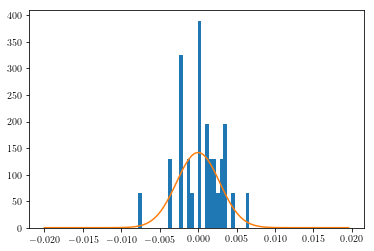

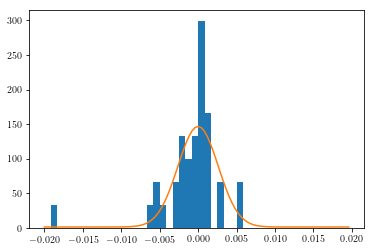

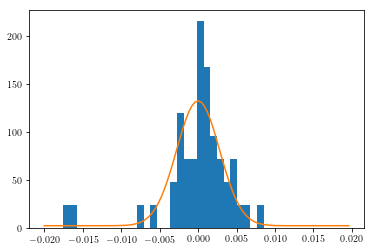

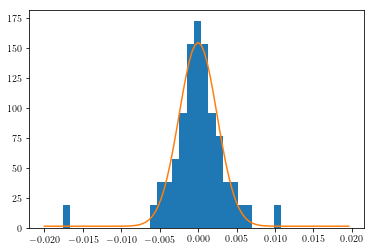

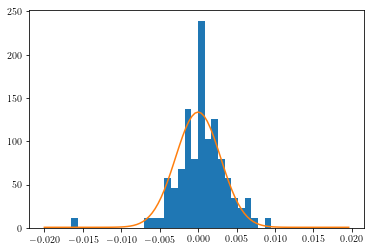

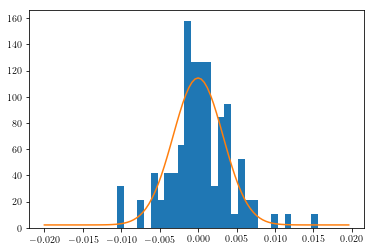

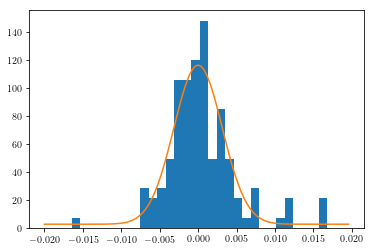

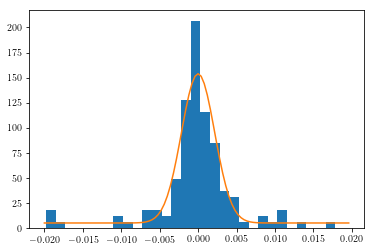

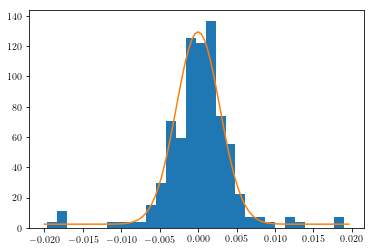

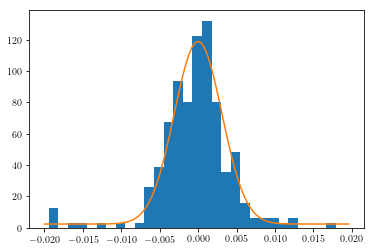

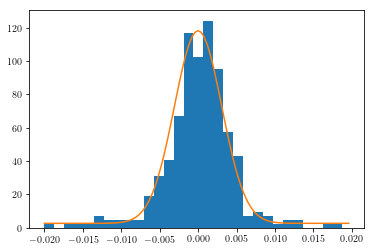

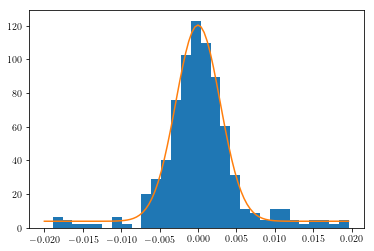

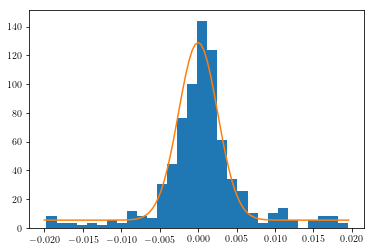

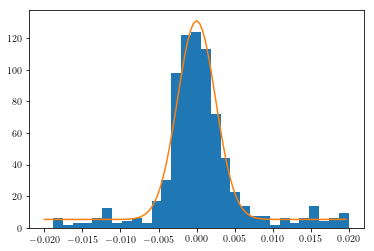

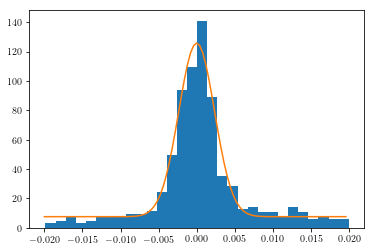

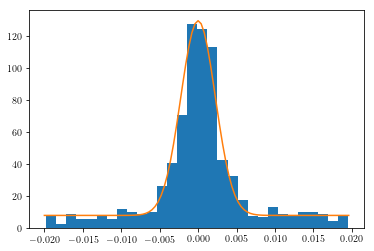

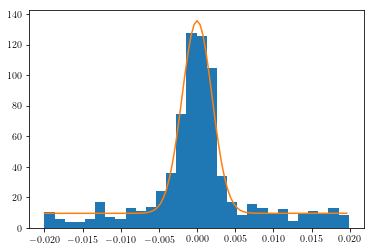

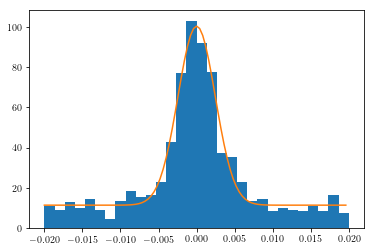

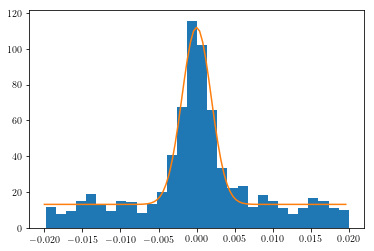

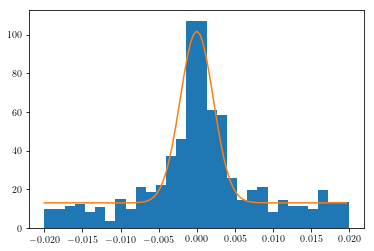

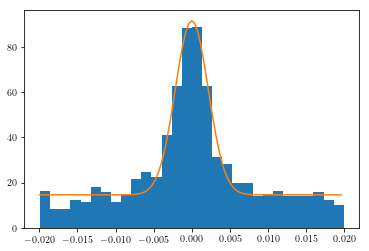

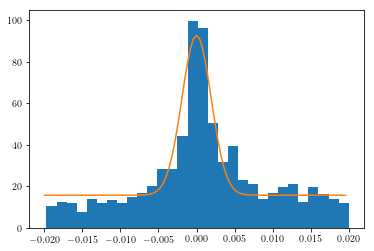

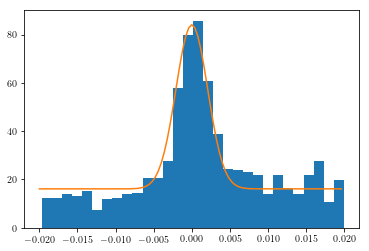

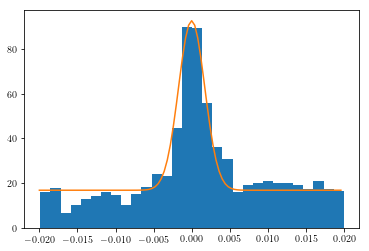

In [130]:
# ftol = 1e-8

bin_edge = np.logspace(np.log10(0.1), np.log10(6), num=25)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]
bin_mid = (bin_min*bin_max)**0.5
ddz = np.arange(100)*0.0004-0.02

Results = []
Chain = []
Sigma = []
for i in range(24):
    r_mask = (R>=bin_min[i])*(R<bin_max[i])
    args = (dz[r_mask], Lambda[r_mask])
    result = op.minimize(nll, p0, args=args, method = method, options={'ftol':1e-8, 'disp':True}, bounds = bounds)

    mplot.figure()
    mplot.hist(dz[r_mask], bins=30, normed=1)
    sigma0, alpha, p = result.x
    print(result.x)
    sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04 #*(B*ddz -0.02*B + 1./0.04)
    mplot.plot(ddz, like)
    Results.append(result.x)
    

    # MCMC
    nwalkers = 256
    start_p0 = result.x
    ndim = len(start_p0)
    r1 = np.min((np.abs(bounds[0][0] - start_p0[0]), np.abs(bounds[0][1] - start_p0[0])))
    r2 = np.min((np.abs(bounds[1][0] - start_p0[1]), np.abs(bounds[1][1] - start_p0[1])))
    r3 = np.min((np.abs(bounds[2][0] - start_p0[2]), np.abs(bounds[2][1] - start_p0[2])))

    #Set up initial positions
    p0_walkers = [np.random.rand(ndim)*np.array([r1,r2,r3])*0.1 + start_p0 for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

    print("Running sampler...")
    num_samps = 100
    sampler.run_mcmc(p0_walkers, num_samps)

    print("Done running sampler")
    chain = sampler.flatchain
    lnlike = sampler.flatlnprobability
    Chain.append(chain)
    Sigma.append(sigma)

Results = np.array(Results)
Chain = np.array(Chain)
Sigma = np.array(Sigma)

In [121]:
splash = np.load('splashback_cov_l20_100_sdss.npz')
# splash_r = np.load('splashback_cov_l20_100_sdss_redder_bin25.npz')
# splash_b = np.load('splashback_cov_l20_100_sdss_bluer_bin25.npz')

# splash = splash_b

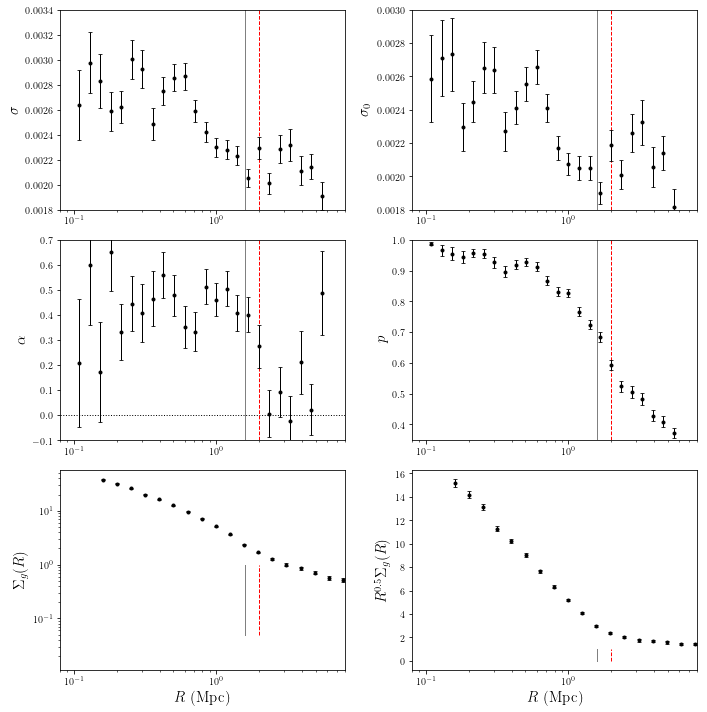

In [123]:
Rsh = 2
Rsp = 1.6

mean = []
err = []
sigma_mean = []
sigma_err = []

for i in range(24):
    mean.append(np.mean(Chain[i], axis=0))
    err.append(np.std(Chain[i], axis=0))
    
    r_mask = (R>=bin_min[i])*(R<bin_max[i])
    sigma_mean.append(np.mean(Chain[i][:,0]* (np.mean(Lambda[r_mask])/30.0)**Chain[i][:,1]))
    sigma_err.append(np.std(Chain[i][:,0]* (np.mean(Lambda[r_mask])/30.0)**Chain[i][:,1]))

    

mean = np.array(mean)
err = np.array(err)
sigma_mean = np.array(sigma_mean)
sigma_err = np.array(sigma_err)


mplot.figure(figsize=(10,10))

mplot.subplot(321)
mplot.errorbar(bin_mid, sigma_mean, yerr=sigma_err,c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.plot([Rsh,Rsh], [0.0018,0.0034], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [0.0018,0.0034], ls='-', color='grey',lw=1)

mplot.ylim(0.0018,0.0034)
mplot.xlim(0.08,8)
mplot.ylabel('$\\sigma$', fontsize=15)
mplot.xscale('log')
# mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(322)
mplot.errorbar(bin_mid, mean[:,0], yerr=err[:,0],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.plot([Rsh,Rsh], [0.0018,0.003], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [0.0018,0.003], ls='-', color='grey',lw=1)

mplot.ylim(0.0018,0.003)
mplot.xlim(0.08,8)
mplot.ylabel('$\\sigma_{0}$', fontsize=15)
mplot.xscale('log')
# mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(323)
mplot.errorbar(bin_mid, mean[:,1], yerr=err[:,1],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(-0.1,0.7)
mplot.xlim(0.08,8)
mplot.plot([0.05,8], [0.0,0.0], ls=':', color='k',lw=1)
mplot.plot([Rsh,Rsh], [-0.1,0.7], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [-0.1,0.7], ls='-', color='grey',lw=1)

mplot.ylabel('$\\alpha$', fontsize=15)
mplot.xscale('log')
# mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(324)
mplot.errorbar(bin_mid, mean[:,2], yerr=err[:,2],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.plot([Rsh,Rsh], [0.35,1.0], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [0.35,1.0], ls='-', color='grey',lw=1)

mplot.ylim(0.35,1.0)
mplot.xlim(0.08,8)
mplot.ylabel('$p$', fontsize=15)
mplot.xscale('log')
# mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(325)
mplot.errorbar(splash['r_data'], splash['sg_mean'], yerr=splash['sg_sig'],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.plot([Rsh,Rsh], [0.05,1], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [0.05,1], ls='-', color='grey',lw=1)

mplot.ylabel('$\Sigma_g (R)$', fontsize=15)
mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)
mplot.xlim(0.08,8)
# mplot.ylim(0.05,1)

mplot.subplot(326)
mplot.errorbar(splash['r_data'], splash['r_data']**0.5*splash['sg_mean'], yerr=splash['r_data']**0.5*splash['sg_sig'],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.plot([Rsh,Rsh], [0.,1], ls='--', color='r',lw=1)
mplot.plot([Rsp,Rsp], [0.,1], ls='-', color='grey',lw=1)

mplot.ylabel('$R^{0.5}\Sigma_g (R)$', fontsize=15)
mplot.xscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)
mplot.xlim(0.08,8)
# mplot.ylim(0.,1)

mplot.tight_layout()    
mplot.savefig('DensityPhasespace.pdf')